In [1]:
import sys
from pathlib import Path

# Resolve current working directory (for notebooks)
project_root = Path().resolve()

# Walk up until 'src/' is found
while not (project_root / 'src').exists() and project_root != project_root.parent:
    project_root = project_root.parent

# Add to Python path
sys.path.append(str(project_root))

print("Project root set to:", project_root)


Project root set to: C:\Users\jonat\fraud-detection-project


In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
# !pip install xgboost

from src.data_loader import load_raw_data, merge_data
from src.preprocessing import drop_high_missing, build_preprocessor
from src.utils import add_missing_flags, frequency_encode
from src.training import apply_smote, train_and_evaluate
import joblib



In [3]:
raw_dir = project_root / "data" / "raw"
processed_dir = project_root / "data" / "processed"
model_dir = project_root / "models" / "trained_model"
model_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Load raw data
transaction, identity = load_raw_data(raw_dir)
print("Transaction sample:")
print(transaction.head())
print("Identity sample:")
print(identity.head())


Loaded transaction shape: (590540, 394)
Loaded identity shape: (144233, 41)
Transaction columns: ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V6

In [5]:
# Merge
df = merge_data(transaction, identity)
print("Merged DataFrame info:")
print(df.info())
print("Merged sample:")
print(df.head())

Merged data shape: (590540, 434)
Merged DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB
None
Merged sample:
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0         987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                

In [6]:
# Check missing
missing = df.isnull().mean().sort_values(ascending=False)
print("Top missing cols:")
print(missing.head(20))


Top missing cols:
id_24    0.991962
id_25    0.991310
id_07    0.991271
id_08    0.991271
id_21    0.991264
id_26    0.991257
id_27    0.991247
id_23    0.991247
id_22    0.991247
dist2    0.936284
D7       0.934099
id_18    0.923607
D13      0.895093
D14      0.894695
D12      0.890410
id_03    0.887689
id_04    0.887689
D6       0.876068
id_33    0.875895
id_10    0.873123
dtype: float64


In [7]:
# Drop high missing
df = drop_high_missing(df)
print("After drop:", df.shape)


Dropped 74 high-missing columns
After drop: (590540, 360)


In [8]:
# Add missing flags
df = add_missing_flags(df)
print("After adding flags:", df.shape)

After adding flags: (590540, 360)


In [9]:
# Frequency encode object columns
cat_cols = df.select_dtypes(include='object').columns.tolist()
print("Categorical columns to encode:", cat_cols)
df = frequency_encode(df, cat_cols, max_unique=500)
df.drop(columns=cat_cols, inplace=True)
print("Shape after encoding and dropping cat columns:", df.shape)

Categorical columns to encode: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
Shape after encoding and dropping cat columns: (590540, 359)


In [10]:
# Extract target and features
target = 'isFraud'
X = df.drop(columns=['TransactionID', target])
y = df[target]
print("X shape:", X.shape)
print("y value counts:")
print(y.value_counts())

X shape: (590540, 357)
y value counts:
isFraud
0    569877
1     20663
Name: count, dtype: int64


In [11]:
# Preprocessing
preprocessor, num_cols, cat_cols = build_preprocessor(X)
X_processed = preprocessor.fit_transform(X)
print("Processed X shape:", X_processed.shape)

Processed X shape: (590540, 357)


In [12]:
joblib.dump(preprocessor, processed_dir / "preprocessor.pkl")
joblib.dump(X.columns.tolist(), processed_dir / "feature_columns.pkl")
print("Preprocessor and feature columns saved.")

Preprocessor and feature columns saved.


In [13]:
# Save processed (pre-SMOTE) data
pd.DataFrame(X_processed).to_csv(processed_dir / "X_processed.csv", index=False)
y.to_csv(processed_dir / "y_processed.csv", index=False)
pd.concat([pd.DataFrame(X_processed), y.reset_index(drop=True)], axis=1).to_csv(
    processed_dir / "processed_full.csv", index=False
)
print("Saved preprocessed datasets to:", processed_dir)

Saved preprocessed datasets to: C:\Users\jonat\fraud-detection-project\data\processed


In [14]:
# Apply SMOTE
X_bal, y_bal = apply_smote(X_processed, y)
print("After SMOTE - X shape:", X_bal.shape)
print("After SMOTE - y distribution:\n", pd.Series(y_bal).value_counts())

Applied SMOTE. New class balance:
isFraud
0    569877
1    569877
Name: count, dtype: int64
After SMOTE - X shape: (1139754, 357)
After SMOTE - y distribution:
 isFraud
0    569877
1    569877
Name: count, dtype: int64


In [15]:
# Save SMOTE-balanced datasets
pd.DataFrame(X_bal).to_csv(processed_dir / "X_smote.csv", index=False)
pd.Series(y_bal).to_csv(processed_dir / "y_smote.csv", index=False)
print("Saved SMOTE-balanced datasets to:", processed_dir)

Saved SMOTE-balanced datasets to: C:\Users\jonat\fraud-detection-project\data\processed


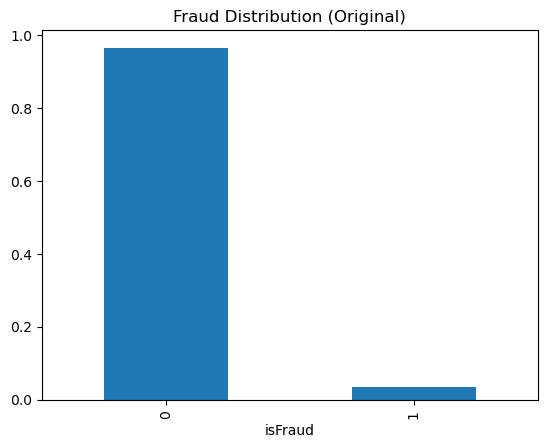

In [16]:
# Plot fraud distribution
y.value_counts(normalize=True).plot(kind='bar')
plt.title("Fraud Distribution (Original)")
plt.show()


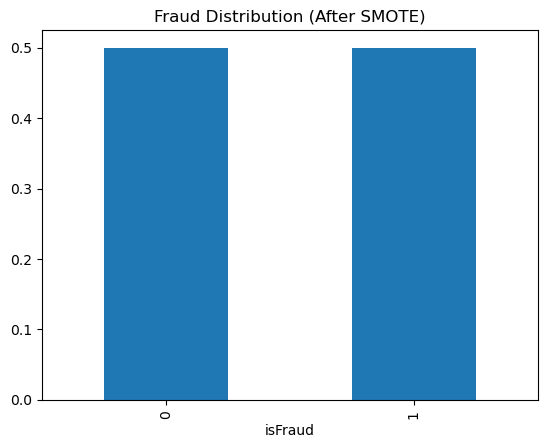

In [17]:
y_bal.value_counts(normalize=True).plot(kind='bar')
plt.title("Fraud Distribution (After SMOTE)")
plt.show()